In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten 
from keras.models import Model
from keras import optimizers
from keras.utils import np_utils
import cv2
import matplotlib.pyplot as plt
from tensorflow import keras
from PIL import Image
import PIL

In [ ]:
!pip install efficientnet
!pip install Pillow

     |████████████████████████████████| 50 kB 2.7 MB/s 


In [ ]:
!pip install git+https://github.com/qubvel/efficientnet

  Cloning https://github.com/qubvel/efficientnet to /tmp/pip-req-build-i0dk3ab_
  Running command git clone -q https://github.com/qubvel/efficientnet /tmp/pip-req-build-i0dk3ab_


In [ ]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train, y_train),(x_test, y_test) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [ ]:
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

In [ ]:
def resize_effi(img):
  img = img.reshape(28,28).astype('float32') / 255.0
  img = Image.fromarray(img)
  img = img.resize((32,32), PIL.Image.ANTIALIAS)  #리사이징
  img = np.stack((img,)*1, axis=2)                #1채널
  return img

In [ ]:
x_train2 = [resize_effi(img) for img in x_train]
x_train2 = np.asarray(x_train2)

x_test2 = [resize_effi(img) for img in x_test]
x_test2 = np.asarray(x_test2)

In [ ]:
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

In [ ]:
X_train3 = np.full((60000, 32, 32, 3), 0.0)

for i, s in enumerate(x_train2):
    X_train3[i] = cv2.cvtColor(s, cv2.COLOR_GRAY2RGB) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


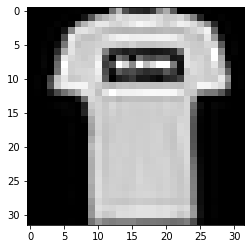

In [ ]:
g= plt.imshow(X_train3[1])

In [ ]:
test3 = np.full((10000, 32, 32, 3), 0.0)

for i, s in enumerate(x_test2):
    test3[i] = cv2.cvtColor(s, cv2.COLOR_GRAY2RGB) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


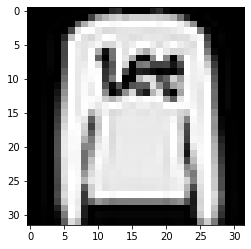

In [ ]:
g = plt.imshow(test3[1])

In [ ]:
X_train3.shape, test3.shape

((60000, 32, 32, 3), (10000, 32, 32, 3))

In [ ]:
y_train = keras.utils.to_categorical(y_train, 10)
y_train

array([[0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
y_test = keras.utils.to_categorical(y_test, 10)
y_test

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
base_model = keras.applications.EfficientNetB3(weights=None, include_top=False,input_shape = (32,32,3), classes=10) #input 채널 : 3

In [ ]:
base_model.summary()  ## efficient net

Model: "efficientnetb3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescaling_2 (Rescaling)         (None, 32, 32, 3)    0           input_3[0][0]                    
__________________________________________________________________________________________________
normalization_2 (Normalization) (None, 32, 32, 3)    7           rescaling_2[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 33, 33, 3)    0           normalization_2[0][0]            
_____________________________________________________________________________________

In [ ]:
base_model.trainable = True   # base_model(efficientnet : trainable)

In [ ]:
num_class=10

with tf.device('/device:GPU:0'):
  # model layer
  model = keras.models.Sequential()
  model.add(base_model)                                           # model : efficientnet b3
  model.add(keras.layers.GlobalMaxPooling2D())                    # Maxpooling layer
  model.add(keras.layers.Dense(num_class, activation='softmax'))  # dense layer, classification


  # optimizer, loss, 성능평가 척도 설정
  model.compile(optimizer='adam',
                loss="categorical_crossentropy",
                metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb3 (Functional)  (None, 1, 1, 1536)        10783535  
_________________________________________________________________
global_max_pooling2d_5 (Glob (None, 1536)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)                15370     
Total params: 10,798,905
Trainable params: 10,711,602
Non-trainable params: 87,303
_________________________________________________________________


In [ ]:
# 모델 학습
with tf.device('/device:GPU:0'):
  history9  = model.fit(X_train3, y_train,epochs=10,batch_size = 128,validation_data=(test3,y_test))

Epoch 1/10
469/469 [==============================] - 106s 185ms/step - loss: 0.9875 - accuracy: 0.6457 - val_loss: 2.7426 - val_accuracy: 0.1958
Epoch 2/10
469/469 [==============================] - 83s 177ms/step - loss: 0.5248 - accuracy: 0.8070 - val_loss: 0.4566 - val_accuracy: 0.8342
Epoch 3/10
469/469 [==============================] - 83s 176ms/step - loss: 0.4186 - accuracy: 0.8464 - val_loss: 0.3982 - val_accuracy: 0.8574
Epoch 4/10
469/469 [==============================] - 83s 176ms/step - loss: 0.3571 - accuracy: 0.8685 - val_loss: 0.3873 - val_accuracy: 0.8591
Epoch 5/10
469/469 [==============================] - 83s 176ms/step - loss: 0.3209 - accuracy: 0.8821 - val_loss: 0.3541 - val_accuracy: 0.8716
Epoch 6/10
469/469 [==============================] - 88s 187ms/step - loss: 0.2885 - accuracy: 0.8935 - val_loss: 0.3386 - val_accuracy: 0.8822
Epoch 7/10
469/469 [==============================] - 88s 187ms/step - loss: 0.2639 - accuracy: 0.9037 - val_loss: 0.3666 - val_a